***Authors:***


*   *Christiana Nardi*
*   *Eman Ahmed*
*   *Anne-Sophie Frederick*

**Imports and Dataframes:**

In [1]:
#Installs
!pip install datasets
!pip install transformers datasets
!pip install transformers datasets accelerate bitsandbytes scikit-learn

#Imports
from os.path import normpath
import scipy.stats as stats
import requests
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import torch
from transformers import BertForSequenceClassification, BertTokenizer, GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, accuracy_score, confusion_matrix, precision_recall_curve, mean_squared_error, r2_score, log_loss, f1_score
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset
from textblob import TextBlob
from collections import Counter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.2 MB/s eta 0:00:00


In [2]:
kaggle_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", kaggle_path)

100%|██████████| 25.7M/25.7M [00:00<00:00, 60.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


In [3]:
#Building dataframes

path = kaggle_path + "/IMDB Dataset.csv"
kaggle_df = pd.DataFrame()

#Breaking down in chunks to save RAM
chunk_size = 2500
for chunk in pd.read_csv(path, chunksize=chunk_size, nrows=10000):
    kaggle_df = pd.concat([kaggle_df, chunk], ignore_index=True)

**Kaggle Dataset Cleaning and Exploring:**

*Inspecting Data:*

In [4]:
kaggle_df.shape

(10000, 2)

In [5]:
kaggle_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
label_name = 'sentiment'
label = kaggle_df['sentiment']
features = kaggle_df.drop('sentiment', axis=1)
features

,review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...
9995,"Fun, entertaining movie about WWII German spy ..."
9996,Give me a break. How can anyone say that this ...
9997,This movie is a bad movie. But after watching ...
9998,This is a movie that was probably made to ente...


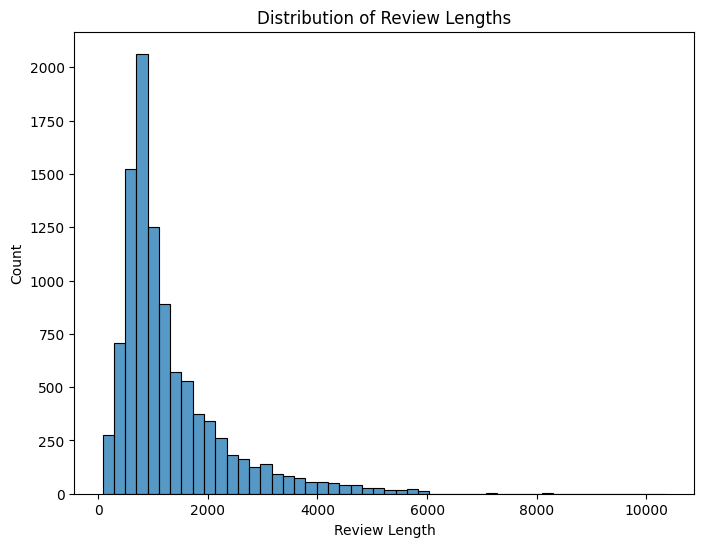

In [7]:
plt.figure(figsize=(8, 6))
kaggle_df['review_length'] = kaggle_df['review'].apply(len)
sns.histplot(kaggle_df['review_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

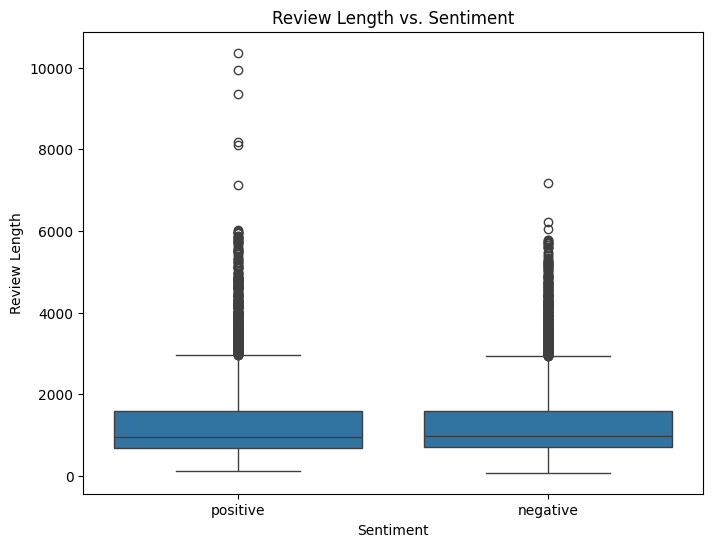

In [8]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='review_length', data=kaggle_df)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

*Handling Outliers:*

In [9]:
winsorized_review_length = stats.mstats.winsorize(kaggle_df['review_length'],limits=[.15,.15])
kaggle_df['winsorized_review_length'] = winsorized_review_length

kaggle_df['winsorized_review_length'] - kaggle_df['review_length']

,0
0,0
1,0
2,0
3,0
4,0
...,...
9995,0
9996,0
9997,0
9998,0


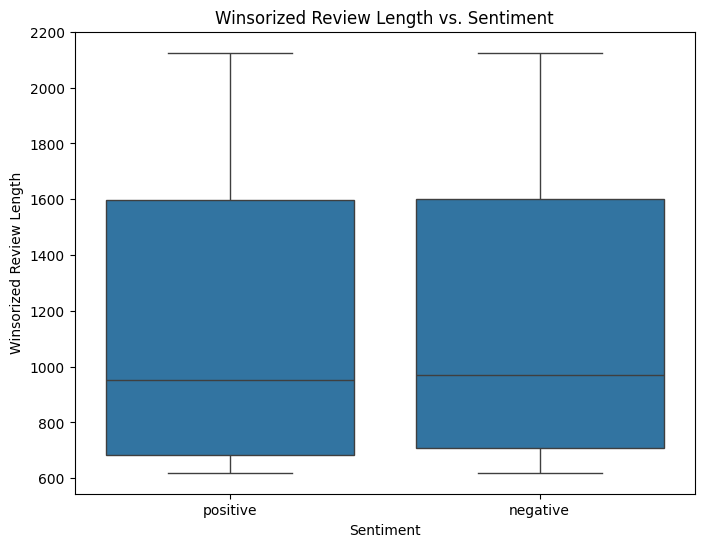

In [10]:
# Box plot after Winsorization
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='winsorized_review_length', data=kaggle_df)
plt.title('Winsorized Review Length vs. Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Winsorized Review Length')
plt.show()

*Checking for Missing Data:*

In [11]:
nan_count = kaggle_df.isnull().sum()
nan_count

,0
review,0
sentiment,0
review_length,0
winsorized_review_length,0


**Feature Engineering:**

In [12]:
reviews=kaggle_df['review'].tolist()
tokens=[review.split() for review in reviews]
# Print tokenized reviews (First 5 for readability)
print("Tokenized Reviews (first 5):")
for i, review_tokens in enumerate(tokens[:5]):
    print(f"Review {i+1}: {review_tokens}")

# Calculate sentiment scores for each tokenized review
sentiment_scores = [TextBlob(' '.join(review)).sentiment.polarity for review in tokens]
print(sentiment_scores)  # List of sentiment scores for each review
# Print sentiment scores (First 5 for readability)
print("\nSentiment Scores (first 5):")


for i, score in enumerate(sentiment_scores[:5]):
    print(f"Review {i+1}: Sentiment Score = {score}")
#positive sentiment score means positive
#negative sentiment score means negative
#0 sentiment score means 0

#Calculate the length of each review (number of words in each review)
review_lengths = [len(review) for review in tokens]

# Calculate word frequencies (word count for each review)
word_frequencies = []
for review in tokens:
    word_freq = Counter(review)  # Count frequency of each word in the review
    word_frequencies.append(word_freq)


Tokenized Reviews (first 5):
Review 1: ['One', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'Oz', 'episode', "you'll", 'be', 'hooked.', 'They', 'are', 'right,', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.<br', '/><br', '/>The', 'first', 'thing', 'that', 'struck', 'me', 'about', 'Oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence,', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'GO.', 'Trust', 'me,', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid.', 'This', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs,', 'sex', 'or', 'violence.', 'Its', 'is', 'hardcore,', 'in', 'the', 'classic', 'use', 'of', 'the', 'word.<br', '/><br', '/>It', 'is', 'called', 'OZ', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'Oswald', 'Maximum', 'Security', 'State', 'Penitentary.', 'It', 'focuses', 'mainly', 'on', 'Emerald', 'City,', 'an', 'e

**Model Testing & Selection:**

In [13]:

#Sample data to save RAM
df_sample = kaggle_df.sample(frac=.1, random_state=1234)

#Creating labeled examples
y=kaggle_df[label_name]
X=kaggle_df[['review']]

#Creating testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234)

In [14]:
#Getting examples
sample_fraction = 0.1
X_sample = X.sample(frac=sample_fraction, random_state=1234)
y_sample = y.sample(frac=sample_fraction, random_state=1234)

#Creating testing and training sets
X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, test_size=0.5, random_state=1234
)

#Using raw text
X_train_llm = X_train['review']
X_test_llm = X_test['review']

In [15]:
#Training with BERT

#Converting labels to numerical values
kaggle_df['label'] = kaggle_df['sentiment'].map({'positive': 1, 'negative': 0})

#Training the model
dataset = Dataset.from_pandas(kaggle_df[['review', 'label']])

train_dataset, val_dataset = dataset.train_test_split(test_size=0.2).values()

model_name = 'prajjwal1/bert-tiny'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

#Preprocessing the data
def preprocess_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=201)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

#Defining the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=2,
)

#Creating a trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

#Training the model
trainer.train()


eval_results = trainer.evaluate()
print(eval_results)

#Saving the model
trainer.save_model('./trained_bert_model')

#Making predictions with BERT
predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids
predicted_probs = predictions.predictions

#Evaluating accuracy score, log loss, and confusion matrix
acc_bert = accuracy_score(true_labels, predicted_labels)
ll_bert = log_loss(true_labels, predicted_probs)
cm_bert = confusion_matrix(true_labels, predicted_labels)

print('BERT Model: \naccuracy score: ' + str(acc_bert))
print(f"Log Loss: {ll_bert}")
print("Confusion Matrix:")
print(cm_bert)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,0.685900
20,0.709800
30,0.699200
40,0.704500
50,0.705100
60,0.710400
70,0.700700
80,0.699100
90,0.696900
100,0.692100


{'eval_loss': 0.49347859621047974, 'eval_runtime': 0.9841, 'eval_samples_per_second': 2032.396, 'eval_steps_per_second': 64.02, 'epoch': 2.0}
BERT Model: 
accuracy score: 0.7785
Log Loss: 3.4465722825264224
Confusion Matrix:
[[841 174]
 [269 716]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [16]:
#Training with LaMa

#Converting labels to numerical values
kaggle_df['label'] = kaggle_df['sentiment'].map({'positive': 1, 'negative': 0})

#Training the model
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

#Preprocessing the data
def preprocess_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=201)

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

#Defining the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=2,
)

#Creating a trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

#Training the model
trainer.train()


eval_results = trainer.evaluate()
print(eval_results)

#Saving the model
trainer.save_model('./trained_lama_model')

#Making predictions with LaMa
predictions = trainer.predict(val_dataset)
predicted_probs = predictions.predictions[0]
predicted_labels = predicted_probs.argmax(-1)

true_labels = predictions.label_ids

#Evaluating accuracy score, log loss, and confusion matrix
acc_lama = accuracy_score(true_labels, predicted_labels)
ll_lama = log_loss(true_labels, predicted_probs)
cm_lama = confusion_matrix(true_labels, predicted_labels)

print('LaMa Model: \naccuracy score: ' + str(acc_lama))
print(f"Log Loss: {ll_lama}")
print("Confusion Matrix:")
print(cm_lama)


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
10,0.724800
20,0.725300
30,0.715300
40,0.714900
50,0.715000
60,0.716400
70,0.708700
80,0.721200
90,0.699300
100,0.703500


{'eval_loss': 0.2858552932739258, 'eval_runtime': 17.3263, 'eval_samples_per_second': 115.431, 'eval_steps_per_second': 3.636, 'epoch': 2.0}
LaMa Model: 
accuracy score: 0.889
Log Loss: 0.9453159438486797
Confusion Matrix:
[[903 112]
 [110 875]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [17]:
#Training with GPT

#Training the model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

#Preprocessing the data
def preprocess_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=201)


train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

#Defining the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=2,
)

#Creating a trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

#Training the model
trainer.train()


eval_results = trainer.evaluate()
print(eval_results)

#Saving the model
trainer.save_model('./trained_gpt_model')

#Making predictions with GPT
predictions = trainer.predict(val_dataset)
predicted_probs = predictions.predictions
predicted_labels = predicted_probs.argmax(-1)

true_labels = predictions.label_ids

#Evaluating accuracy score, log loss, and confusion matrix
acc_gpt = accuracy_score(true_labels, predicted_labels)
ll_gpt = log_loss(true_labels, predicted_probs)
cm_gpt = confusion_matrix(true_labels, predicted_labels)

print('GPT Model: \naccuracy score: ' + str(acc_gpt))
print(f"Log Loss: {ll_gpt}")
print("Confusion Matrix:")
print(cm_gpt)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss
10,1.154100
20,0.881000
30,0.776600
40,0.798400
50,0.720200
60,0.716900
70,0.726200
80,0.705900
90,0.702800
100,0.703800


Step,Training Loss
10,1.154100
20,0.881000
30,0.776600
40,0.798400
50,0.720200
60,0.716900
70,0.726200
80,0.705900
90,0.702800
100,0.703800


{'eval_loss': 0.28179851174354553, 'eval_runtime': 25.3469, 'eval_samples_per_second': 78.905, 'eval_steps_per_second': 2.486, 'epoch': 2.0}
GPT Model: 
accuracy score: 0.8755
Log Loss: 1.8065181315168266
Confusion Matrix:
[[934  81]
 [168 817]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


**Comparing Model Performances:**

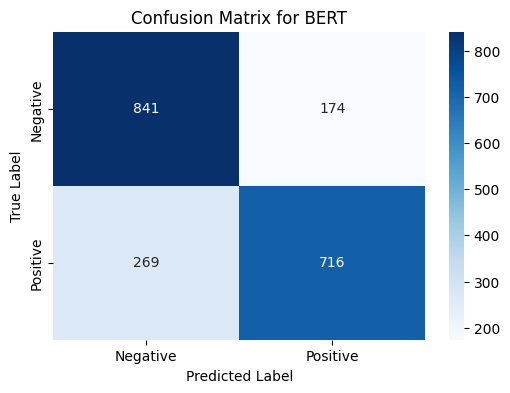

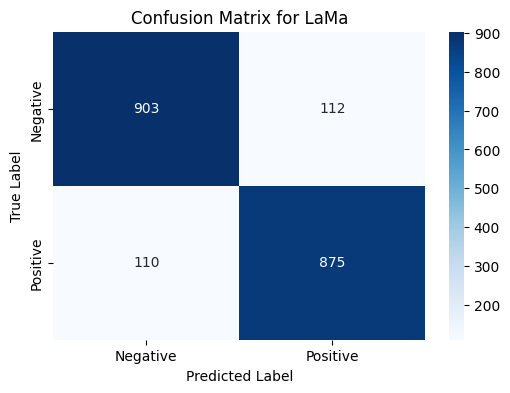

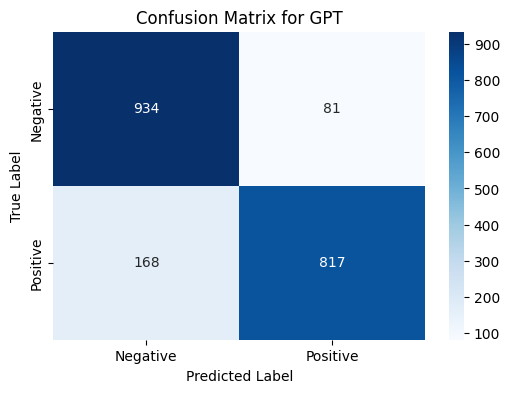

In [18]:
def plot_confusion_matrix(cm, model_name):
  """Plots the confusion matrix for a given model."""
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=['Negative', 'Positive'],
              yticklabels=['Negative', 'Positive'])
  plt.title(f"Confusion Matrix for {model_name}")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

plot_confusion_matrix(cm_bert, "BERT")
plot_confusion_matrix(cm_lama, "LaMa")
plot_confusion_matrix(cm_gpt, "GPT")